# Projeto Final: Interpretabilidade na predição de salários

Introdução:

Motivação:

Perguntas:

## Imports necessários

In [249]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display

# sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#import statsmodels as sm

import sklearn.preprocessing as preprocessing

import seaborn as sns

import warnings
warnings.filterwarnings("ignore") #ignore deprecated warnings

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap

# print the JS visualization code to the notebook
shap.initjs()

## Variáveis

In [250]:
INPUT_FILEPATH = "adult.csv"

TARGET = "income"

N_FOLDS = 10

## Resumo dos Dados


In [251]:
# Leitura do dataset para um DataFrame do Pandas
# (neste caso ele usa o separador default que eh a virgula)
df = pd.read_csv(INPUT_FILEPATH)

# Remove colunas que nao serao usadas
#df = df.drop(["Date", "Location", "RISK_MM"], axis=1)

# Imprime algumas informacoes basicas sobre os dados
print("Numero de linhas: {}".format(df.shape[0]))
print("Numero de colunas: {}".format(df.shape[1]))

# Para tratar dados faltantes
df = df.replace('?',np.nan)
print("Dados faltando: {}".format(df.isna().sum().sum()))

print("\nAmostra:")
with pd.option_context("max_columns", 12): # Limita o numero de cols mostradas
    display(df.head())
    


Numero de linhas: 48842
Numero de colunas: 15
Dados faltando: 6465

Amostra:


,age,workclass,fnlwgt,education,educational-num,marital-status,...,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,...,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,...,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,...,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,...,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,...,Female,0,0,30,United-States,<=50K


### Dados Faltantes


Temos poucos dados faltando, nao é necessário excluir nenhuma coluna, apenas algumas linhas.

In [252]:
df.isnull().sum().to_frame("Dados faltando").join(
    (df.isnull().sum().to_frame("%")*100/len(df)).round(2))

,Dados faltando,%
age,0,0.00
workclass,2799,5.73
fnlwgt,0,0.00
education,0,0.00
educational-num,0,0.00
marital-status,0,0.00
occupation,2809,5.75
relationship,0,0.00
race,0,0.00
gender,0,0.00


In [253]:
n_before = df.shape[0]
df = df.dropna(axis=0, how="any")
print("\nLinhas removidas: {}".format(n_before - df.shape[0]))

# Certifica que nao ha mais dados faltando
assert df.isnull().sum().sum() == 0


Linhas removidas: 3620


## Análise exploratória

In [254]:
# Colunas com dados categoricos
cat_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"]

# Colunas com dados numericos (reais)
real_cols = ["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]

### Features Categóricas

In [255]:
for c in cat_cols:
    display((df[c].value_counts().sort_index()/len(df)*100).round(2).to_frame(c +" (%)").T)

,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
workclass (%),3.11,6.86,73.65,3.64,8.39,4.3,0.05


,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
education (%),2.7,3.58,1.28,0.49,0.99,1.82,1.49,3.33,4.33,16.74,1.2,32.69,5.56,0.16,1.74,21.89


,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
marital-status (%),13.92,0.07,46.56,1.22,32.28,3.12,2.82


,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
occupation (%),12.25,0.03,13.31,13.23,3.27,4.52,6.57,10.63,0.51,13.29,2.16,11.96,3.14,5.12


,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
relationship (%),41.28,25.88,2.98,14.65,10.59,4.62


,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
race (%),0.96,2.88,9.35,0.78,86.03


,Female,Male
gender (%),32.5,67.5


,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
native-country (%),0.06,0.36,0.25,0.18,0.29,0.21,0.1,0.33,0.26,0.08,...,0.14,0.39,0.04,0.22,0.12,0.06,0.06,91.31,0.18,0.05


Podemos deletar a coluna "education" pois representa as mesmas informações que "educational-num".

In [256]:
df[["education", "educational-num"]].head(15)

,education,educational-num
0,11th,7
1,HS-grad,9
2,Assoc-acdm,12
3,Some-college,10
5,10th,6
7,Prof-school,15
8,Some-college,10
9,7th-8th,4
10,HS-grad,9
11,Bachelors,13


In [257]:
del df["education"]

### Features numéricas

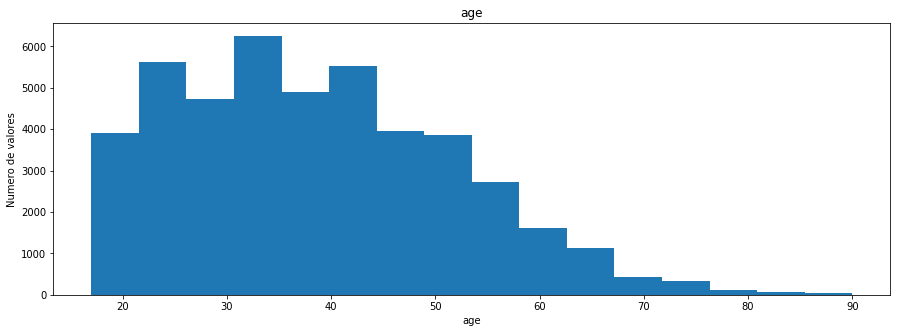

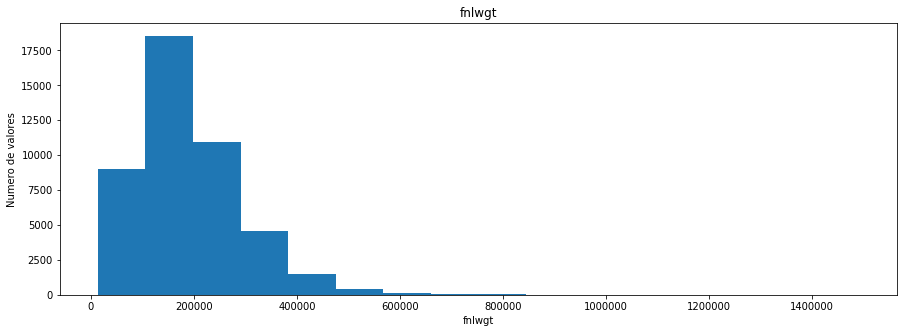

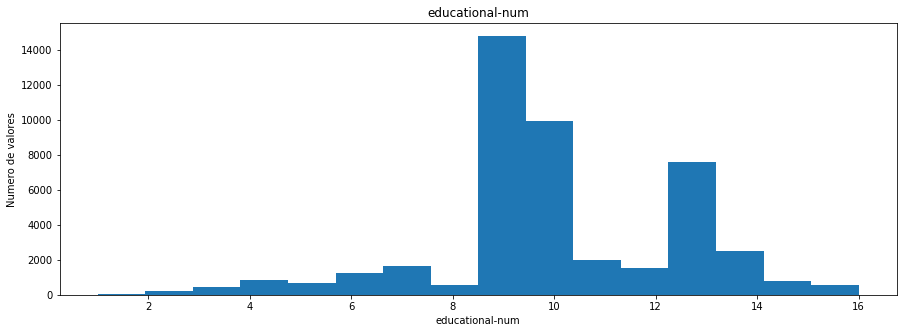

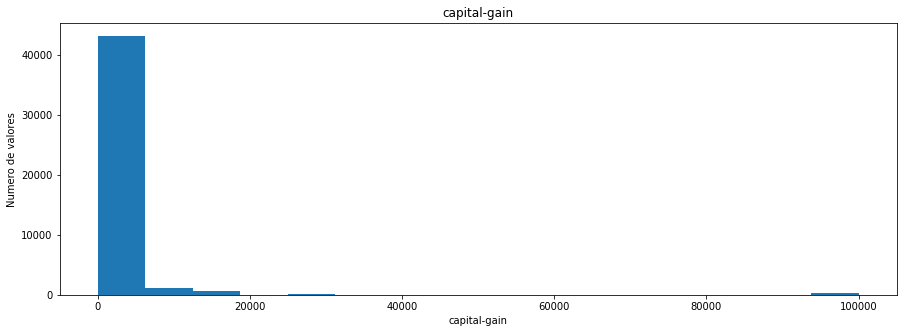

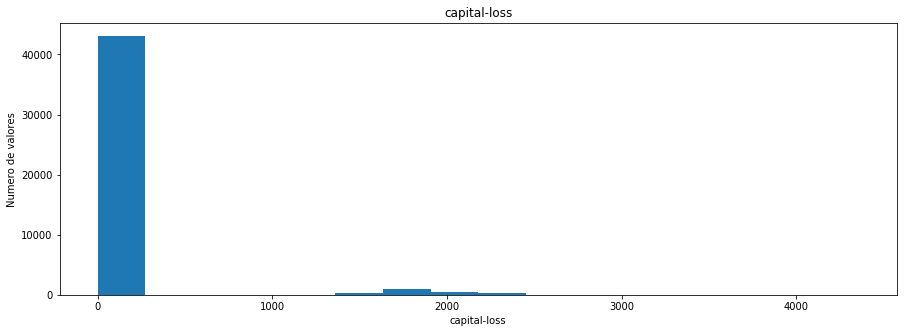

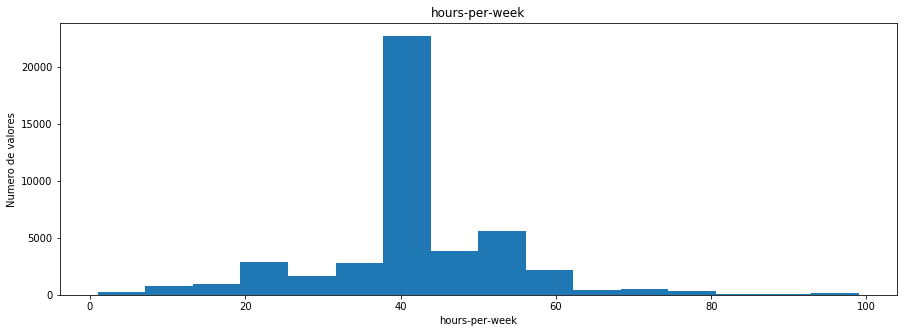

In [258]:
for c in real_cols:
    plt.figure(figsize=(15, 5))
    plt.hist(df[c], bins=16)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("Numero de valores")
    plt.show()

### Target

In [211]:
display((df[TARGET].value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)

,<=50K,>50K
income (%),75.22,24.78


## Preprocessamento

### Dados categóricos

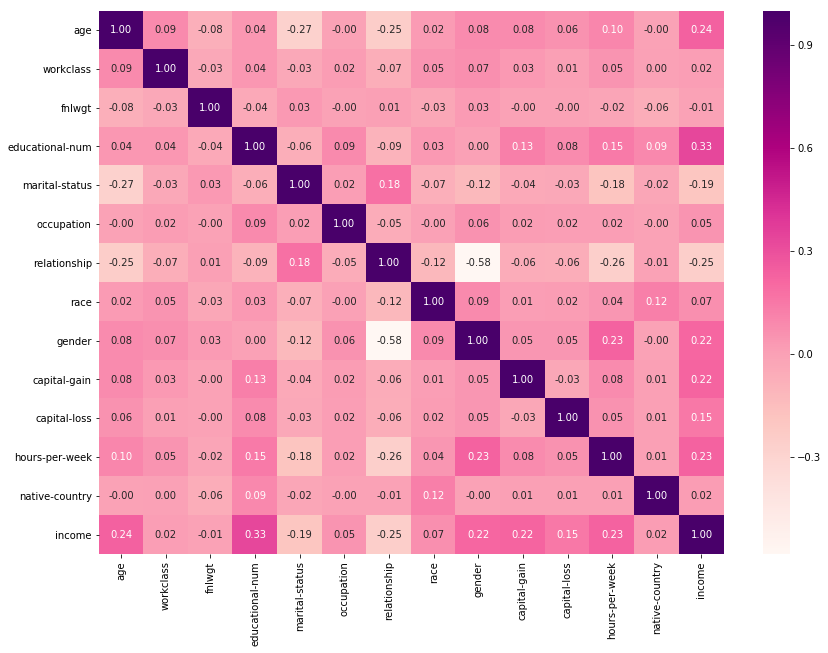

In [212]:
def number_encode_features(df):
    result = df.copy()
    r = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            r[column] = encoders[column].fit_transform(result[column].astype(str))
    return r, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(df)
plt.figure(figsize=(14,10))
sns.heatmap(encoded_data.corr(),annot=True,fmt='.2f', cmap=plt.cm.RdPu)
plt.show()

### Target

In [213]:
display(encoded_data[[TARGET]].sample(10))

,income
9222,0
24133,0
42302,1
7943,0
23167,0
37819,0
36981,0
33824,0
27031,0
26274,0


### Representação dos dados codificados

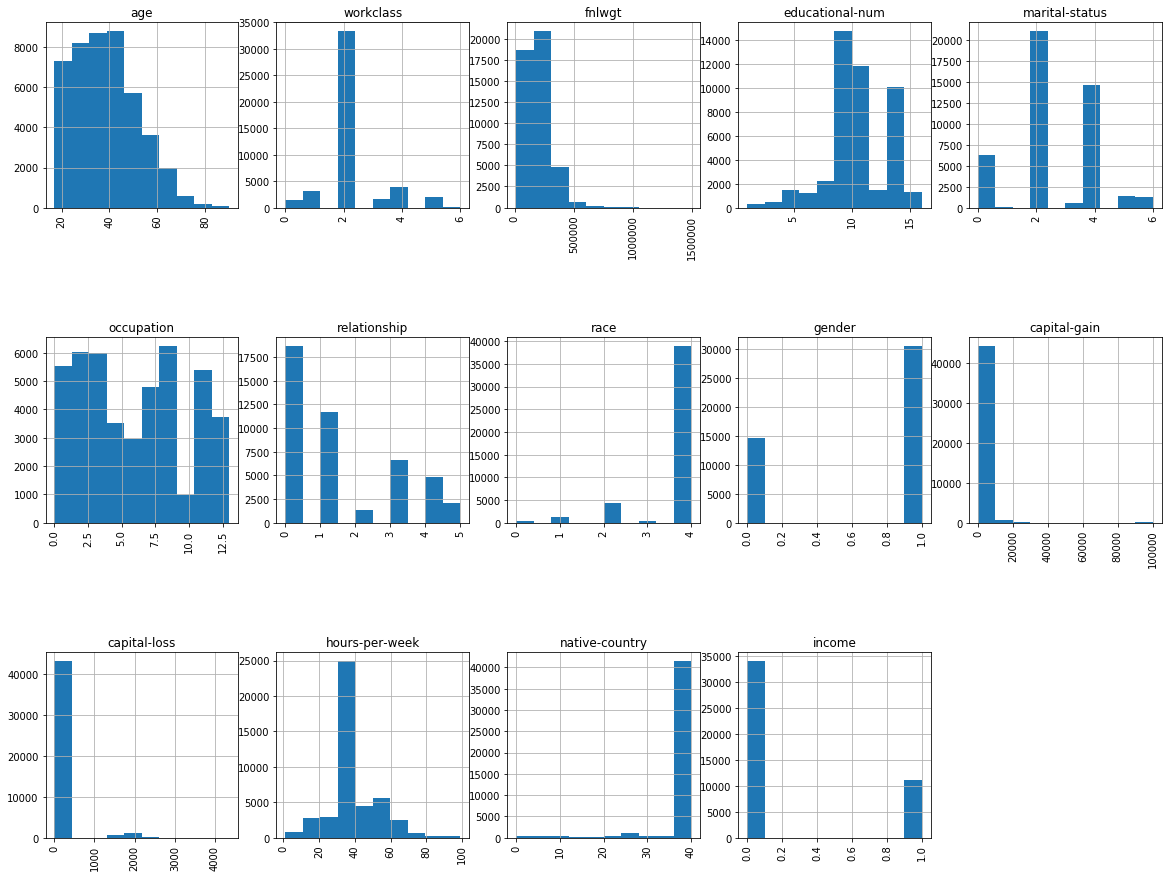

In [214]:
encoded_data, encoders = number_encode_features(df)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

### Lista as features

In [215]:
features = list(encoded_data.columns)
features.remove(TARGET)

print("Target: {}".format(TARGET))
print("Features:")
print("\n".join(["  " + x for x in features]))

Target: income
Features:
  age
  workclass
  fnlwgt
  educational-num
  marital-status
  occupation
  relationship
  race
  gender
  capital-gain
  capital-loss
  hours-per-week
  native-country


### Normalizando o dado

In [216]:
encoded_data[features] = encoded_data[features] - encoded_data[features].mean()
encoded_data[features] = encoded_data[features] / encoded_data[features].std()

### Separação de treino, validação e teste

In [217]:
X = encoded_data[features].values 
y = encoded_data[TARGET].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

kf = KFold(n_splits = N_FOLDS, random_state = 1, shuffle = True)

### Funções básicas para os modelos

In [218]:
bestModelsTestAcc = []
#bestModelsValAcc = []
bestModelsRecall = []
bestModelsPrecision = []
bestModelsF1Score = []
bestModelsPred = []
bestModelsProba = []
models = ["Regressao Logistica", "Decision tree", "Random Forest", "XGB", "LightGB"]

In [219]:
def bestModel(testAcc_model, recall_model, f1_score_model, precision_model, proba, predictions):
    bestModelsTestAcc.append(testAcc_model)
    #bestModelsValAcc.append(valAcc_model)
    bestModelsPrecision.append(precision_model)
    bestModelsRecall.append(recall_model)
    bestModelsF1Score.append(f1_score_model)
    bestModelsProba.append(proba)
    bestModelsPred.append(predictions)

In [220]:
def plot_curva(x, y1, y2, x_label, y_label):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y1, label= "Training")
    plt.plot(x, y2, label= "Validation")
    # distinção para plotar gráfico da decision tree no ponto em que temos altura ilimitada
    if x_label == "max_depth":
        trainAcc, valAcc = decision_tree(None) 
        plt.plot([20], [trainAcc], 'ro',  ms=15, label = 'No depth limit training(y-axis only)')
        plt.plot([20], [valAcc], 'bo', ms=15, label = 'No depth limit 5-fold validation(y-axis only)')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

## Modelos

In [221]:
#baseline
def logistic_regression():
    train_score = []
    val_score = []
        
    for train, val in kf.split(X_train, y_train):
            
        classifier = LogisticRegression(solver='newton-cg')
        classifier = classifier.fit(X_train[train], y_train[train])

        train_score.append(classifier.score(X_train[train], y_train[train]))
        val_score.append(classifier.score(X_train[val], y_train[val]))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    
    return trainAcc, valAcc

In [222]:
trainAcc, valAcc = logistic_regression()

model = LogisticRegression(solver='newton-cg')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
testAcc = metrics.accuracy_score(y_test, y_pred)

y_proba = (model.predict_proba(X_test))[:, 1]
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)

print("Acuracia de test: {:.3}".format(testAcc))

bestModel(testAcc, recall, f1, precision, y_proba, y_pred)

Acuracia de test: 0.82


In [223]:
def decision_tree(H):
    train_score = []
    val_score = []
        
    for train, val in kf.split(X_train, y_train):
           
        classifier = DecisionTreeClassifier(max_depth= H, max_features=13, 
                                            min_samples_leaf=100,random_state=10)
        classifier = classifier.fit(X_train[train], y_train[train])

        train_score.append(classifier.score(X_train[train], y_train[train]))
        val_score.append(classifier.score(X_train[val], y_train[val]))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    
    return trainAcc, valAcc

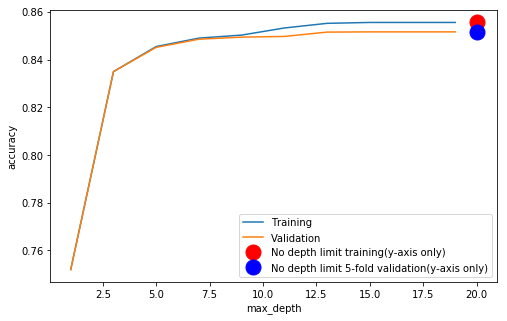

In [224]:
acc_modelTrain = []
acc_modelVal = []
max_depth = list(range(1,21,2)) #Valores usados para variar a altura da árvore 
for i in max_depth:
    trainAcc, valAcc = decision_tree(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(max_depth, acc_modelTrain, acc_modelVal, "max_depth", "accuracy")

Melhor modelo

In [225]:
model = DecisionTreeClassifier(max_depth= 12, max_features=13, 
                                            min_samples_leaf=100,random_state=10)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
testAcc = metrics.accuracy_score(y_test, y_pred)

y_proba = (model.predict_proba(X_test))[:, 1]
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)

print("Acuracia de test: {:.3}".format(testAcc))

bestModel(testAcc, recall, f1, precision, y_proba, y_pred)

Acuracia de test: 0.855


In [226]:
def random_forest(N):
    train_score = []
    val_score = []
        
    for train, val in kf.split(X, y):

        classifier = ensemble.RandomForestClassifier(n_estimators=N, max_features=5, min_samples_leaf=50, 
                                                     random_state=24)
        classifier = classifier.fit(X[train], y[train])

        train_score.append(classifier.score(X[train], y[train]))
        val_score.append(classifier.score(X[val], y[val]))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)

    return trainAcc, valAcc

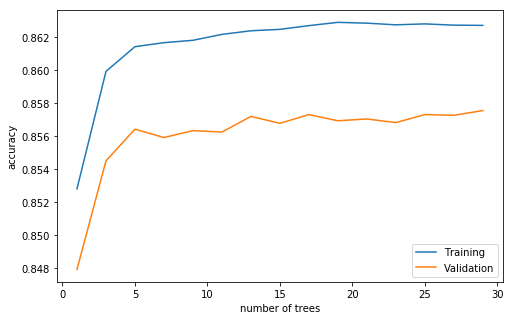

In [227]:
acc_modelTrain = []
acc_modelVal = []
n_trees = list(range(1,31,2)) #Valores do número de árvores a ser variado
for i in n_trees:
    trainAcc, valAcc = random_forest(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_trees, acc_modelTrain, acc_modelVal, "number of trees", "accuracy")

In [228]:
model = ensemble.RandomForestClassifier(max_depth= 13, max_features=5, min_samples_leaf=50, 
                                                     random_state=24)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
testAcc = metrics.accuracy_score(y_test, y_pred)

y_proba = (model.predict_proba(X_test))[:, 1]
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)

print("Acuracia de test: {:.3}".format(testAcc))

bestModel(testAcc, recall, f1, precision, y_proba, y_pred)

Acuracia de test: 0.855


In [229]:
def xgb(N):
    train_score = []
    val_score = []
        
    for train, val in kf.split(X_train, y_train):
            
        classifier = XGBClassifier(n_estimators=N, importance_type='gain')
        classifier = classifier.fit(X_train[train], y_train[train])

        train_score.append(classifier.score(X_train[train], y_train[train]))
        val_score.append(classifier.score(X_train[val], y_train[val]))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    
    return trainAcc, valAcc

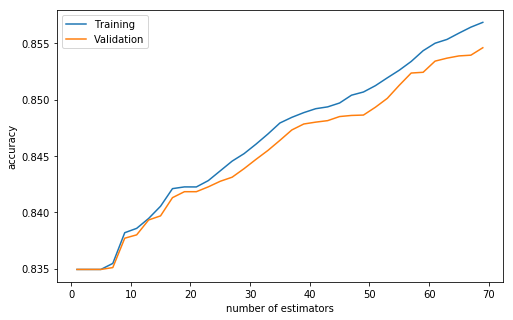

In [230]:
acc_modelTrain = []
acc_modelVal = []
n_iter = list(range(1,71,2)) #Valores do número de estimadores a ser variado
for i in n_iter:
    trainAcc, valAcc = xgb(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_iter, acc_modelTrain, acc_modelVal, "number of estimators", "accuracy")

In [231]:
model = XGBClassifier(n_estimators=70, importance_type='gain')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
testAcc = metrics.accuracy_score(y_test, y_pred)

y_proba = (model.predict_proba(X_test))[:, 1]
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)

print("Acuracia de test: {:.3}".format(testAcc))

bestModel(testAcc, recall, f1, precision, y_proba, y_pred)

Acuracia de test: 0.859


In [232]:
def light_gboost(N):
    train_score = []
    val_score = []
        
    for train, val in kf.split(X_train, y_train):
            
        classifier = LGBMClassifier(n_estimators=N)
        classifier = classifier.fit(X_train[train], y_train[train])

        train_score.append(classifier.score(X_train[train], y_train[train]))
        val_score.append(classifier.score(X_train[val], y_train[val]))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    
    return trainAcc, valAcc

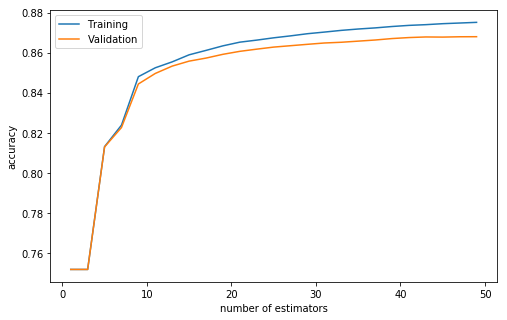

In [233]:
acc_modelTrain = []
acc_modelVal = []
n_iter = list(range(1,51,2)) #Valores do número de estimadores a ser variado
for i in n_iter:
    trainAcc, valAcc = light_gboost(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_iter, acc_modelTrain, acc_modelVal, "number of estimators", "accuracy")

In [234]:
model = LGBMClassifier(n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
testAcc = metrics.accuracy_score(y_test, y_pred)

y_proba = (model.predict_proba(X_test))[:, 1]
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)

print("Acuracia de test: {:.3}".format(testAcc))

bestModel(testAcc, recall, f1, precision, y_proba, y_pred)

Acuracia de test: 0.87


In [248]:
raw_data = {'Acurácia de Teste' : bestModelsTestAcc, 'Recall': bestModelsRecall, 
            'F1 Score': bestModelsF1Score, 'Precision': bestModelsPrecision}
    
df_metrics = pd.DataFrame(raw_data, columns = ["Acurácia de Teste", "Recall", "F1 Score", 
                                       "Precision"], index = models)
display(df)

,Acurácia de Teste,Recall,F1 Score,Precision
Regressao Logistica,0.820289,0.460184,0.558882,0.711474
Decision tree,0.854530,0.605092,0.672993,0.758059
Random Forest,0.855267,0.593716,0.669927,0.768583
XGB,0.858550,0.566360,0.664548,0.803922
LightGB,0.869539,0.651138,0.711769,0.784851


In [236]:
bestModelsAUC = np.zeros(5)
def roc():
    i = 0
    for name, pred in zip(models, bestModelsProba):
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
        auc = np.trapz(tpr, fpr)
        bestModelsAUC[i] = auc
        plt.figure(figsize=(7, 5))
        lw = 2
        plt.plot(fpr, tpr, color='royalblue',lw=2)
        plt.plot([0, 1], [0, 1], color='Black', lw=2, ls='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Curva ROC ('+name+')  -  AUC: '+str(auc))
        plt.show()
        i+=1

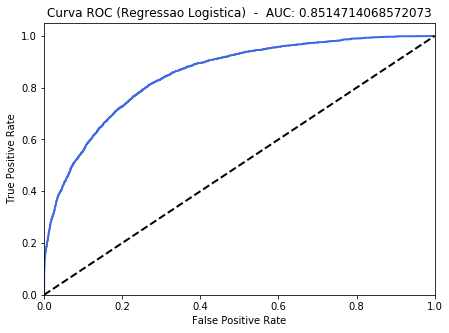

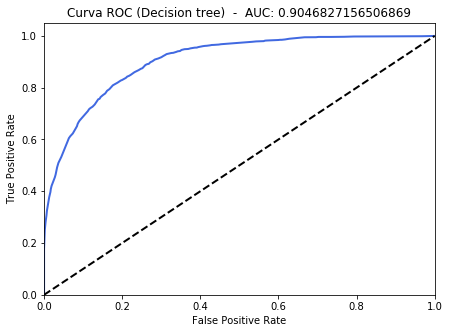

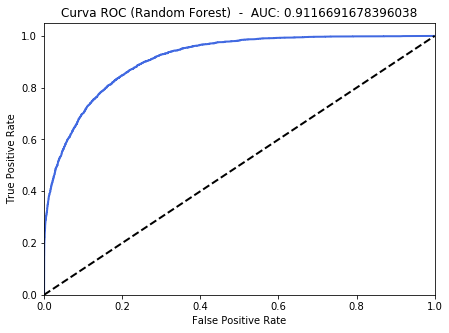

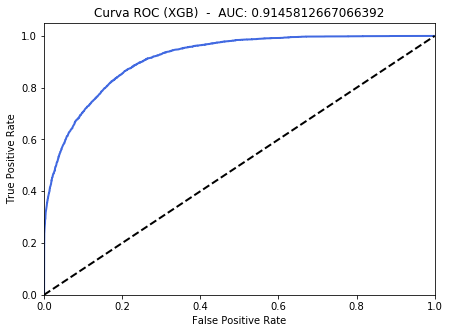

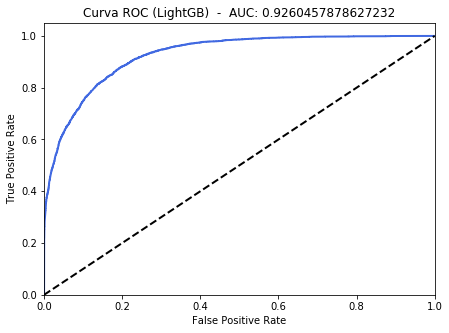

In [237]:
roc()

In [238]:
# Matriz de Confusao
classes = ['0', '1']
def matriz_confusao():
    i = 0
    for name, pred in zip(models, bestModelsPred):
    
        cm = metrics.confusion_matrix(y_test, pred)

        fig, ax = plt.subplots(figsize=(7, 7))
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.RdPu)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title="Matriz de Confusão - "+name,
               ylabel="Real",
               xlabel="Predito")

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], "d"),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max()/2. else "black")
        fig.tight_layout()
        plt.show()

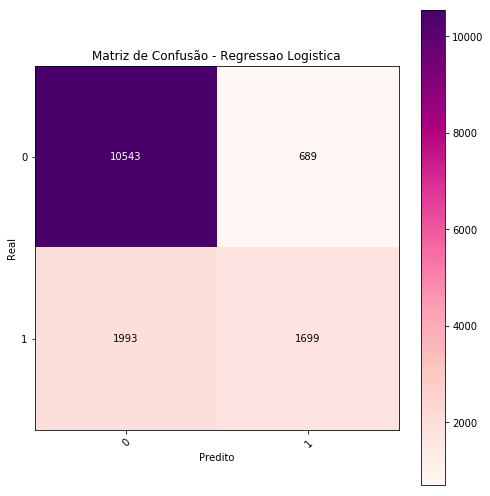

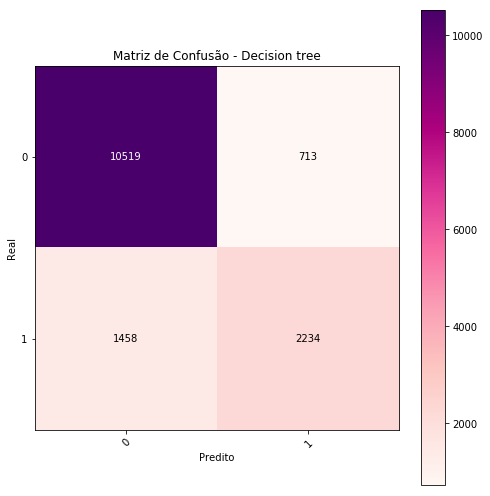

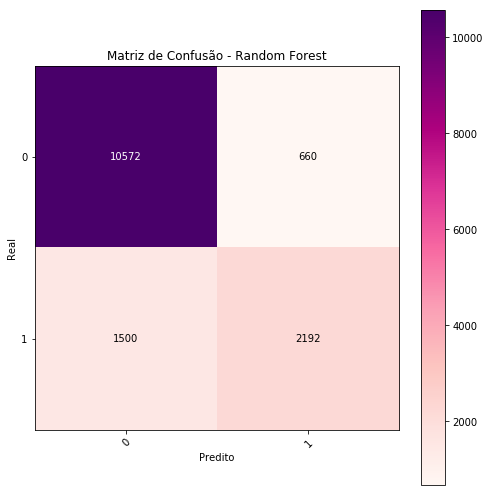

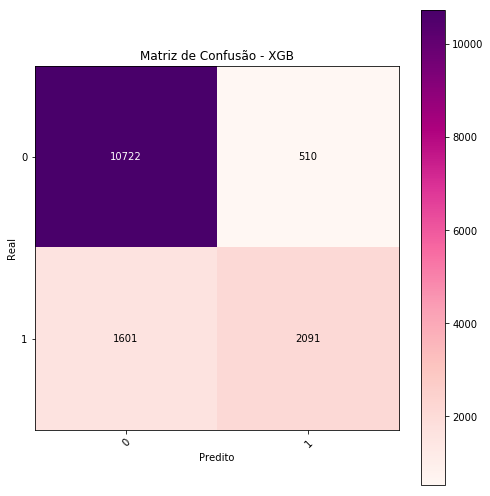

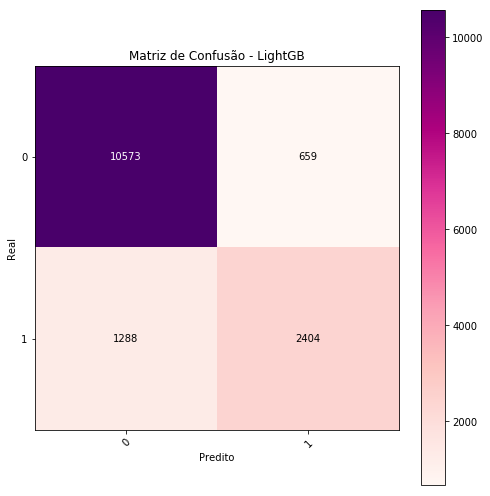

In [239]:
matriz_confusao()

## Melhor modelo : LGBM

In [240]:
model = LGBMClassifier(n_estimators=50)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred, y_test))


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(encoded_data[features])

0.8695389975877781


In [259]:
shap.force_plot(explainer.expected_value, shap_values[0,:], df[features].iloc[0,:])

In [260]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], df[features].iloc[:1000,:])

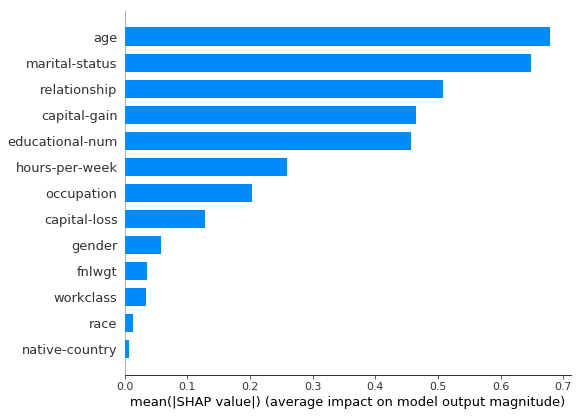

In [261]:
shap.summary_plot(shap_values, df[features], plot_type="bar")

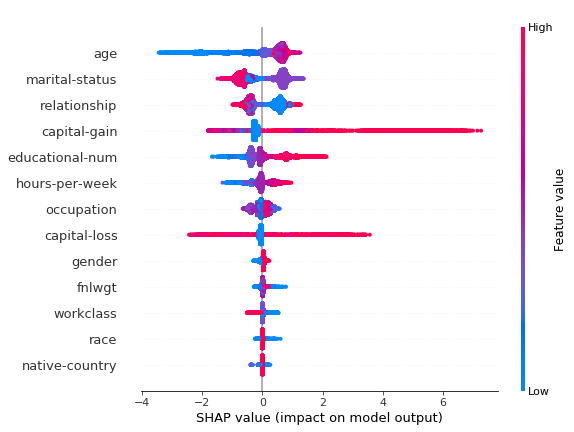

In [262]:
shap.summary_plot(shap_values, encoded_data[features])

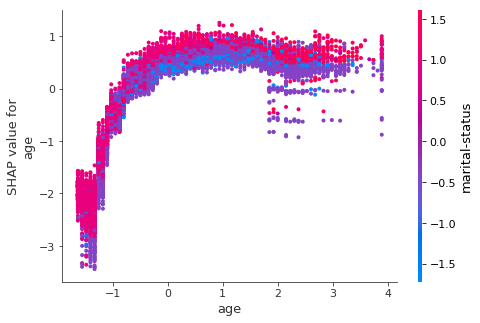

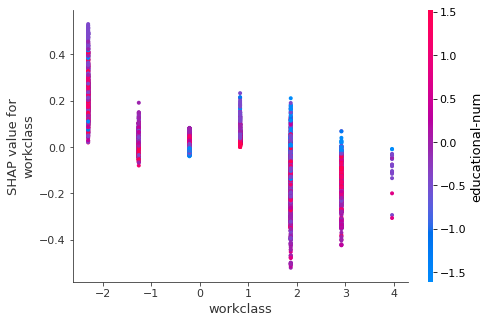

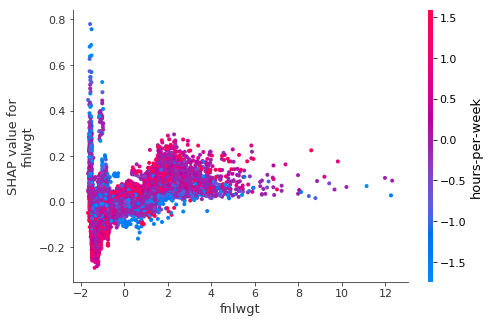

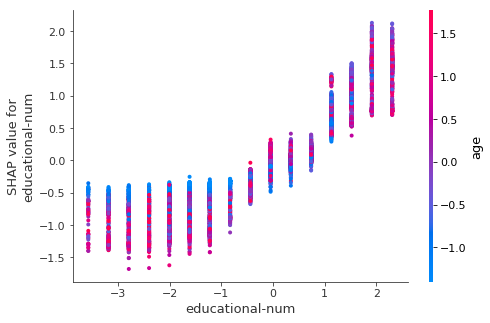

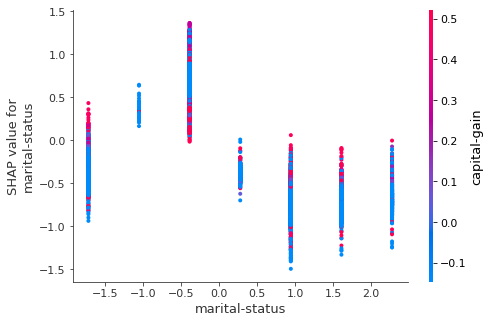

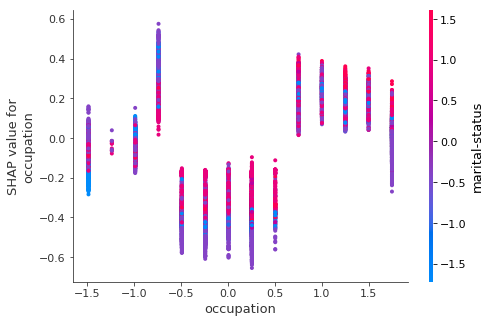

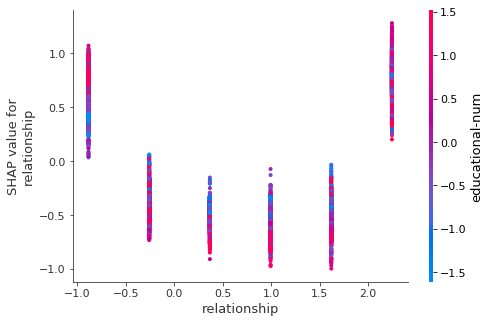

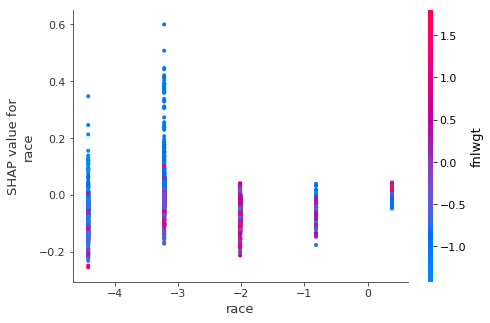

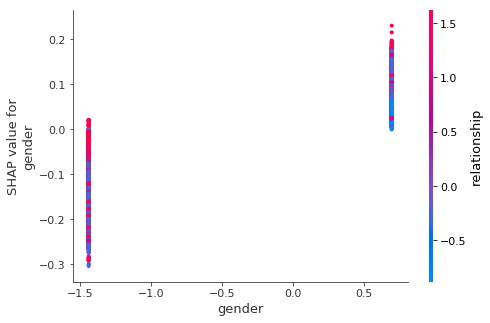

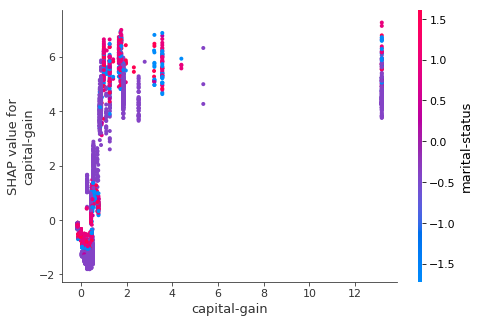

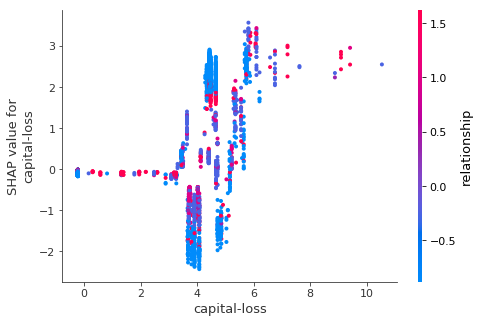

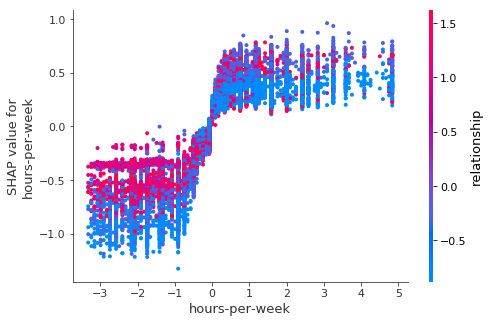

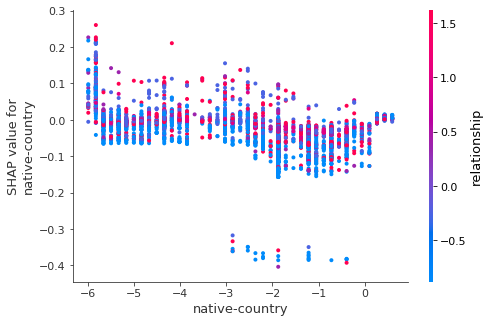

In [280]:
for name in df[features].columns:
    shap.dependence_plot(name, shap_values, encoded_data[features])

## Simple supervised cluster

In [281]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000,:])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:])

In [282]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)


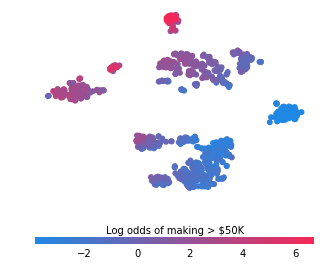

In [286]:

f = plt.figure(figsize=(5,5))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = plt.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
plt.gca().axis("off")
plt.show()

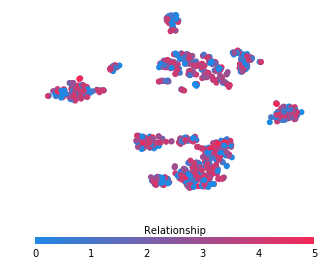

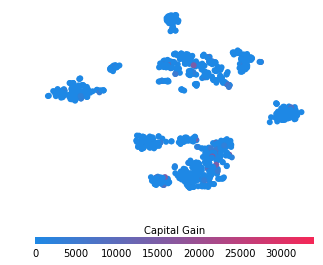

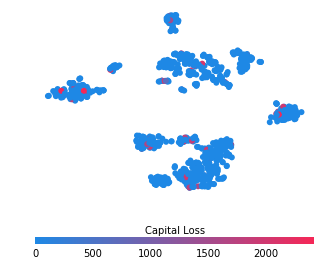

In [288]:
for feature in ["Relationship", "Capital Gain", "Capital Loss"]:
    f = plt.figure(figsize=(5,5))
    plt.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X[feature].values[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = plt.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    plt.gca().axis("off")
    plt.show()